In [4]:
labels_path = r"C:\Users\Aditya Koul\OneDrive\Desktop\CNN_beauty\labels.txt"
image_dir = r"C:\Users\Aditya Koul\OneDrive\Desktop\CNN_beauty\Images\Images"

In [5]:
import pandas as pd

df = pd.read_csv(labels_path, sep=' ', header=None)
df.columns = ['image_name', 'beauty_score']
df.head()

,image_name,beauty_score
0,CF437.jpg,2.883333
1,AM1384.jpg,2.466667
2,AM1234.jpg,2.150000
3,AM1774.jpg,3.750000
4,CF215.jpg,3.033333


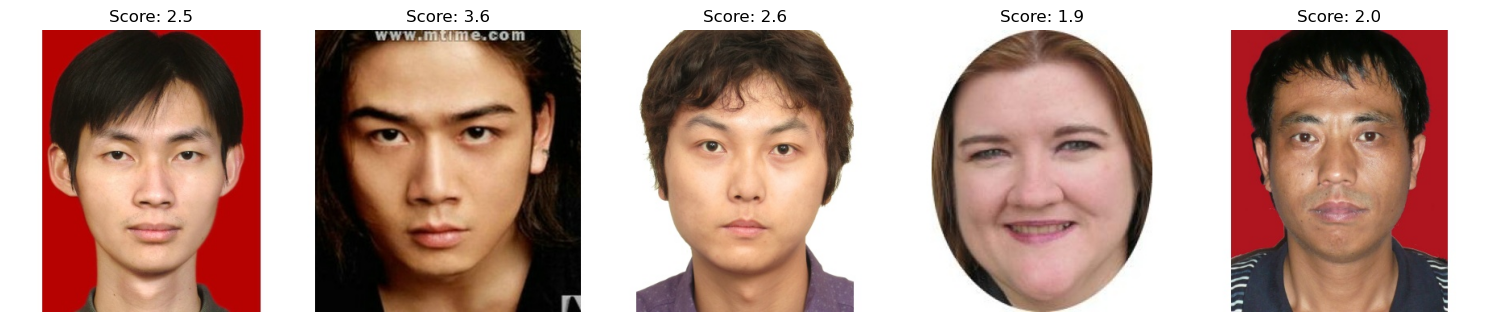

In [6]:
import matplotlib.pyplot as plt
import cv2
import os

def show_samples(df, image_dir, n=5):
    sample = df.sample(n)
    plt.figure(figsize=(15, 5))
    for i, row in enumerate(sample.itertuples(), 1):
        img_path = os.path.join(image_dir, row.image_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i)
        plt.imshow(img)
        plt.title(f'Score: {row.beauty_score:.1f}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_samples(df, image_dir)


In [7]:
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import r2_score

IMG_SIZE = (224, 224)

class BeautyDataset(Sequence):
    def __init__(self, df, image_dir, batch_size=32, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        X, y = [], []
        for row in batch_df.itertuples():
            img_path = os.path.join(self.image_dir, row.image_name)
            img = load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img) / 255.0
            X.append(img_array)
            y.append(row.beauty_score)
        return np.array(X), np.array(y)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_gen = BeautyDataset(train_df, image_dir)
test_gen = BeautyDataset(test_df, image_dir, shuffle=False)


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)  # One beauty score
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_model((*IMG_SIZE, 3))
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       5,537,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,631,169 (21.48 MB)

 Trainable params: 5,631,169 (21.48 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(train_gen, validation_data=test_gen, epochs=10)


Epoch 1/10


C:\Users\Aditya Koul\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


138/138 ━━━━━━━━━━━━━━━━━━━━ 87s 617ms/step - loss: 1.7404 - mae: 0.9270 - val_loss: 0.3417 - val_mae: 0.4630
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 85s 618ms/step - loss: 0.3242 - mae: 0.4514 - val_loss: 0.3094 - val_mae: 0.4321
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 86s 622ms/step - loss: 0.2914 - mae: 0.4222 - val_loss: 0.2869 - val_mae: 0.4153
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 86s 622ms/step - loss: 0.2431 - mae: 0.3849 - val_loss: 0.2501 - val_mae: 0.3867
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 86s 621ms/step - loss: 0.2139 - mae: 0.3595 - val_loss: 0.2652 - val_mae: 0.3957
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 86s 621ms/step - loss: 0.1954 - mae: 0.3468 - val_loss: 0.2413 - val_mae: 0.3782
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 86s 624ms/step - loss: 0.1718 - mae: 0.3243 - val_loss: 0.2634 - val_mae: 0.3904
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 84s 612ms/step - loss: 0.1849 - mae: 0.3361 - val_loss: 0.2410 - val_mae: 0.3758
Epoch 9/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 85s

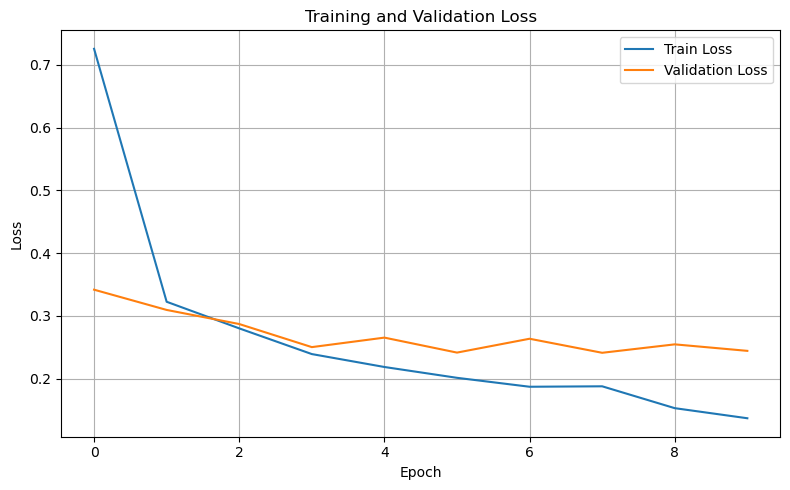

R² Score: 0.48419001722621047


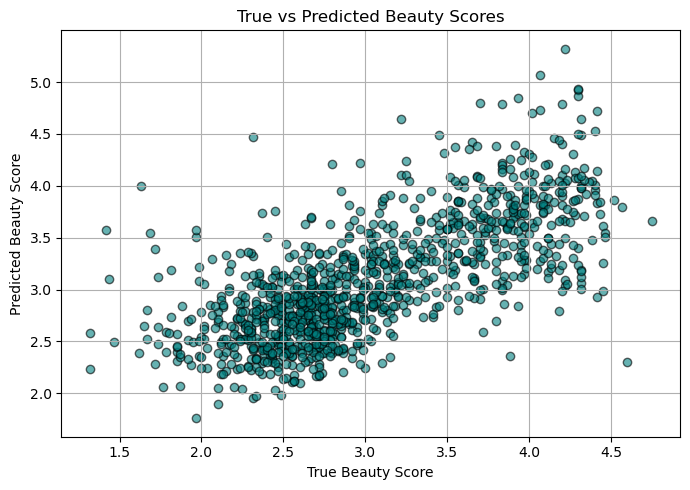

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np

# 📈 Plot: Training and Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 🧠 Predict safely using batch-wise accumulation
y_pred = []
y_true = []

for i in range(len(test_gen)):
    X_batch, y_batch = test_gen[i]
    preds = model.predict(np.expand_dims(X_batch, axis=0) if X_batch.ndim == 3 else X_batch, verbose=0).flatten()
    y_pred.extend(preds)
    y_true.extend(y_batch)

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# 📊 R² Score
print("R² Score:", r2_score(y_true, y_pred))

# 📌 Scatter Plot: Predicted vs Actual
plt.figure(figsize=(7, 5))
plt.scatter(y_true, y_pred, alpha=0.6, color='teal', edgecolors='k')
plt.xlabel("True Beauty Score")
plt.ylabel("Predicted Beauty Score")
plt.title("True vs Predicted Beauty Scores")
plt.grid(True)
plt.tight_layout()
plt.show()


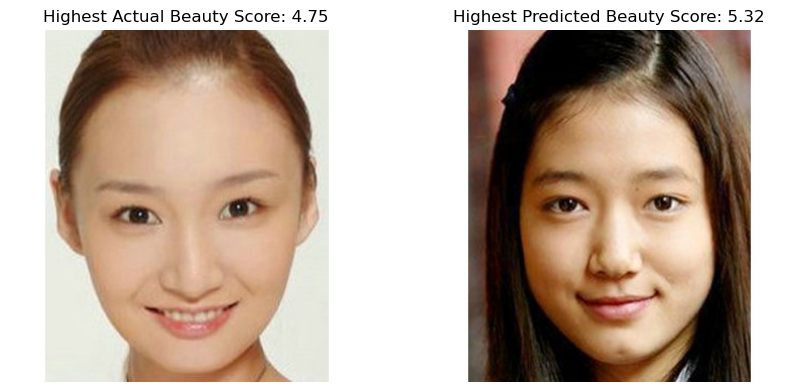

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import os

# Define the image directory
image_folder = r"C:\Users\Aditya Koul\OneDrive\Desktop\CNN_beauty\Images\Images"  # Update with the correct path

# Get all image paths (ensure they are sorted correctly)
image_paths = sorted([os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith('.jpg') or img.endswith('.png')])

max_true_idx = np.argmax(y_true)  
max_pred_idx = np.argmax(y_pred)  

# Load the images
true_max_img = cv2.imread(image_paths[max_true_idx])  
true_max_img = cv2.cvtColor(true_max_img, cv2.COLOR_BGR2RGB)  

pred_max_img = cv2.imread(image_paths[max_pred_idx])  
pred_max_img = cv2.cvtColor(pred_max_img, cv2.COLOR_BGR2RGB)  

# Plot side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(true_max_img)
axes[0].set_title(f"Highest Actual Beauty Score: {y_true[max_true_idx]:.2f}")
axes[0].axis("off")

axes[1].imshow(pred_max_img)
axes[1].set_title(f"Highest Predicted Beauty Score: {y_pred[max_pred_idx]:.2f}")
axes[1].axis("off")

plt.show()


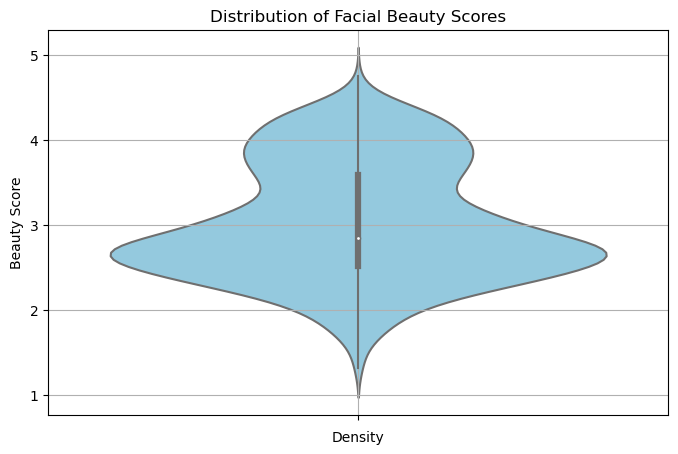

In [24]:
plt.figure(figsize=(8, 5))
sns.violinplot(y=y_true, color="skyblue")
plt.title("Distribution of Facial Beauty Scores")
plt.xlabel("Density")
plt.ylabel("Beauty Score")
plt.grid(True)
plt.show()

C:\Users\Aditya Koul\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


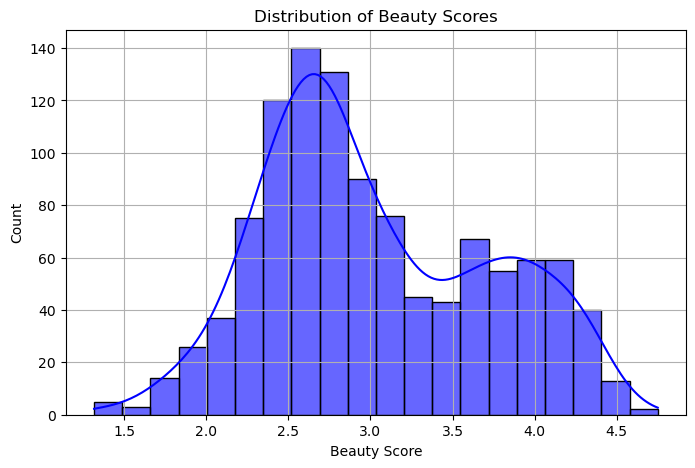

In [23]:
plt.figure(figsize=(8, 5))
sns.histplot(y_true, bins=20, kde=True, color='blue', alpha=0.6)
plt.title("Distribution of Beauty Scores")
plt.xlabel("Beauty Score")
plt.ylabel("Count")
plt.grid(True)
plt.show()


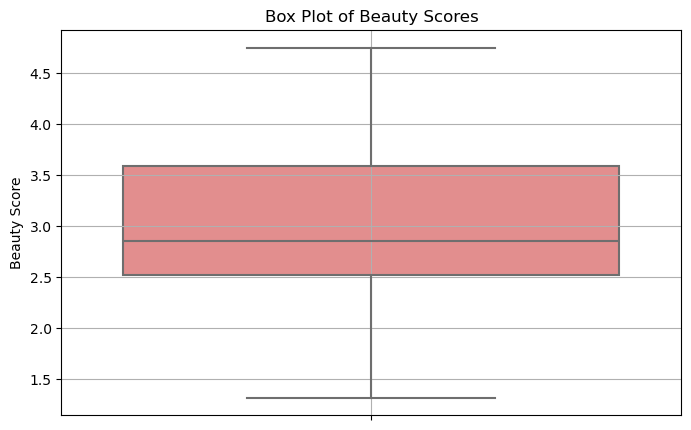

In [25]:
plt.figure(figsize=(8, 5))
sns.boxplot(y=y_true, color="lightcoral")
plt.title("Box Plot of Beauty Scores")
plt.ylabel("Beauty Score")
plt.grid(True)
plt.show()

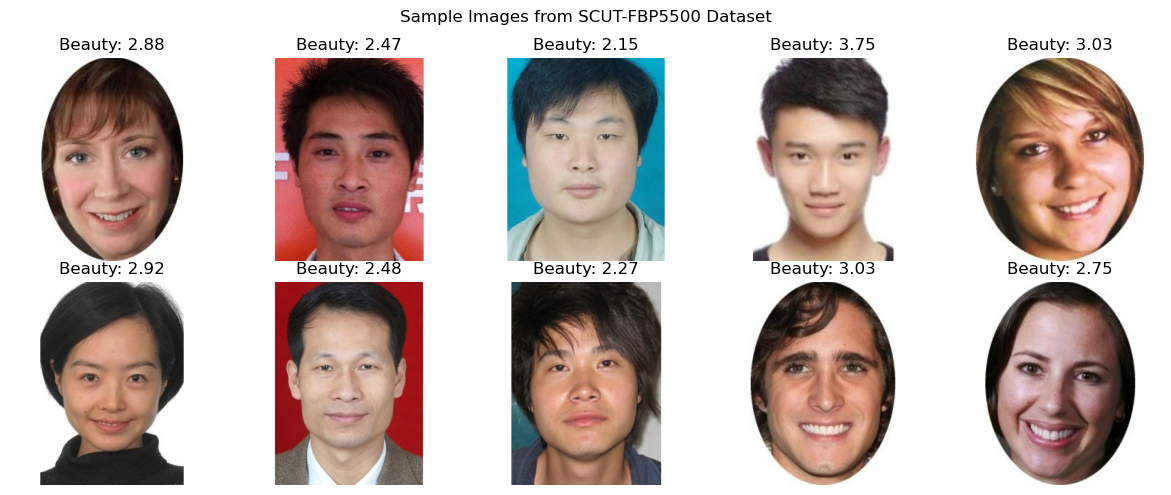

In [30]:
image_paths = []
beauty_scores = []
with open(labels_path, "r") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 2:
            image_paths.append(os.path.join(image_dir, parts[0]))
            beauty_scores.append(float(parts[1]))
beauty_scores = np.array(beauty_scores)

# 🔹 Sample Images from the Dataset
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()
for i in range(10):
    img = cv2.imread(image_paths[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(f"Beauty: {beauty_scores[i]:.2f}")
    axes[i].axis("off")
plt.suptitle("Sample Images from SCUT-FBP5500 Dataset")
plt.tight_layout()
plt.show()

C:\Users\Aditya Koul\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


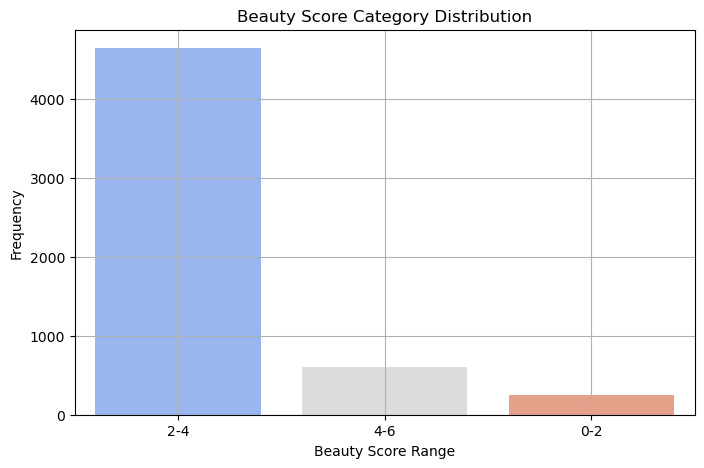

In [34]:
# 🔹 Class Distribution of Beauty Scores (Binned)
bin_ranges = [0, 2, 4, 6, 8, 10]
bin_labels = ["0-2", "2-4", "4-6", "6-8", "8-10"]
beauty_bins = np.digitize(beauty_scores, bins=bin_ranges, right=True)

plt.figure(figsize=(8, 5))
sns.countplot(x=[bin_labels[i-1] for i in beauty_bins], palette="coolwarm")
plt.title("Beauty Score Category Distribution")
plt.xlabel("Beauty Score Range")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()